<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/optimized_position_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#참고 https://losskatsu.github.io/statistics/prob-distribution/#%EC%B0%B8%EA%B3%A0-%ED%99%95%EB%A5%A0%EB%B6%84%ED%8F%AC%EA%B0%84-%EA%B4%80%EA%B3%84%EB%8F%84

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [3]:
stock = Stock('KOSPI')
df = stock.get_price('20000101')
df['Change'] = round(df['Close'] / df['Open'], 4)
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-01-04,102833,106618,101659,105904,195898,1.0299
2000-01-05,100687,102652,98405,98631,257696,0.9796
2000-01-06,101395,101490,95350,96079,203523,0.9476
2000-01-07,94917,97016,93084,94865,215664,0.9995
2000-01-10,97967,99494,97482,98724,240175,1.0077
...,...,...,...,...,...,...
2021-07-05,328529,329893,328529,329321,850406,1.0024
2021-07-06,329544,331351,329544,330521,1029465,1.0030
2021-07-07,330359,330359,327766,328534,1147641,0.9945


In [4]:
# 샘플링
#sampled_df = df.sample(n=10000)
sampled_df = df

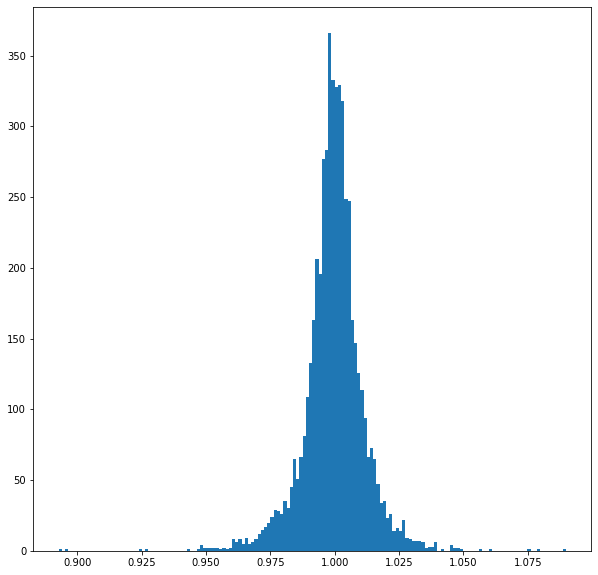

In [5]:
# 확률분포
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 10))
plt.hist(df[np.isfinite(df['Change'])]['Change'], bins= 'auto')
plt.show()

In [6]:
print('lowest 5th percentile: ', round(np.percentile(sampled_df['Change'], 5), 5))
print('highest 5th percentile: ', round(np.percentile(sampled_df['Change'], 95), 5))
print(sum(sampled_df['Change'] > 1.0) / len(sampled_df['Change']))

lowest 5th percentile:  0.9806
highest 5th percentile:  1.0173
0.48842897460018814


In [7]:
# sampled_df의 Change > 1 전날의 데이터 인덱스
pre_increase = df[(df['Change'] > 1).shift(-1).fillna(False)].index

In [8]:
df.loc[pre_increase]

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-01-07,94917,97016,93084,94865,215664,0.9995
2000-01-14,95882,97059,93775,94803,224957,0.9887
2000-01-19,96931,96931,93874,93878,235726,0.9685
2000-01-21,92855,94070,91183,92516,255135,0.9963
2000-01-26,89634,90243,87582,88554,231146,0.9880
...,...,...,...,...,...,...
2021-06-23,326573,328188,326307,327619,1069174,1.0032
2021-06-24,328147,329227,327785,328610,1301271,1.0014
2021-06-29,330526,330542,327663,328668,1213046,0.9944


In [9]:
# 전날 관련 확률
print(sum(df.loc[pre_increase]['Change'] < 1) / len(pre_increase))

0.5244701348747591


In [10]:
# 기하분포
# 성공의 확률인 p인 독립시행을 성공이 나올 때까지 계속한다고 할 때, 처음 성공까지 총 시도한 횟수 X의 확률분포.
# Pr(X = x) = p*(1-p)^(x-1)
# 𝝁   : 1/p  
# 𝝈^2 : (1-p)/p^2

# +%가 나올때가지 x의 확률
p = sum(sampled_df['Change'] > 1.0) / len(sampled_df['Change'])
print('p: ', p)
print('mean: ', 1/p)
print('variance: ', (1-p)/(p**2))

p:  0.48842897460018814
mean:  2.0473805855161786
variance:  2.1443866764323922


In [11]:
x = range(1,10)
pr = list(map(lambda x: p*(1-p)**(x-1) , x))

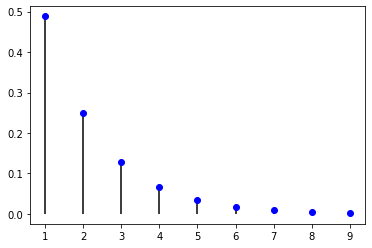

In [12]:
import matplotlib.pyplot as plt

plt.plot(x, pr, 'bo')
plt.vlines(x, 0, pr)
plt.show()

In [13]:
# 음이항분포
# 성공의 확률인 p인 독립시행을 r번째 성공이 나올 때까지 계속한다고 할 때, 처음 성공까지 총 시도한 횟수 X의 확률분포.
# Pr(X = x) = (x-1)C(r-1) * p^r * (1-p)^(x-r)
# 𝝁   : r/p  
# 𝝈^2 : r*(1-p)/p^2

# 5번째 +%가 나올때가지 x의 확률
p = sum(sampled_df['Change'] > 1.0) / len(sampled_df['Change'])
r = 3
print('p: ', p)
print('mean: ', r/p)
print('variance: ', r*(1-p)/(p**2))

p:  0.48842897460018814
mean:  6.142141756548536
variance:  6.433160029297176


In [14]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / (f(r) * f(n-r))

x = range(r,50)
pr = list(map(lambda x: nCr(x-1,r-1) * p**r * (1-p)**(x-r) , x))

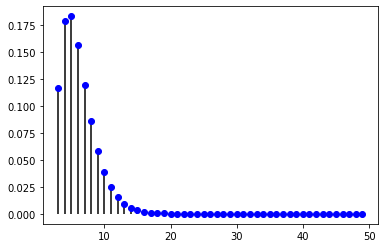

In [15]:
import matplotlib.pyplot as plt

pr = list(map(lambda x: nCr(x-1,r-1) * p**r * (1-p)**(x-r) , x))
plt.plot(x, pr, 'bo')
plt.vlines(x, 0, pr)
plt.show()

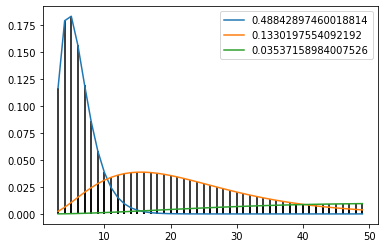

In [16]:
import matplotlib.pyplot as plt

# 각각 0%, 1%, 2% 이상 r번의 시도에 나올 확률 
p = sum(sampled_df['Change'] > 1.0) / len(sampled_df['Change']), sum(sampled_df['Change'] > 1.01) / len(sampled_df['Change']), \
sum(sampled_df['Change'] > 1.02) / len(sampled_df['Change']) 

for i in range(len(p)):
  pr = list(map(lambda x: nCr(x-1,r-1) * p[i]**r * (1-p[i])**(x-r) , x))
  plt.plot(x, pr)
  plt.vlines(x, 0, pr)
plt.legend(p)
plt.show()

In [17]:
# 메모용
#
# 초기하분포
# 비복원추출에서 n개 중에 m개가 원하는 것이고, k번 추출했을때 원하는 것 x개가 뽑힐 확률의 분포이다.
# Pr(X = x) = nCx * (n-m)C(k-x) / nCk
# 𝝁   : k*m/n  
# 𝝈^2 : (k*m/n) * ((n-m)*(n-k)/(n*(n-1)))

# 5번째 +%가 나올때가지 x의 확률
x = 1
n = 3
m = 2
k = 6
#print('p: ', nCr(n,x) * nCr(n-m,k-x) / nCr(n,k)) 오류 뜸 ㅆ
print('mean: ', k*m/n)
print('variance: ', ((k*m/n) * ((n-m)*(n-k))/(n*(n-x))))

mean:  4.0
variance:  -2.0
